In [1]:
from typing import Tuple

import torch
from torch import nn, optim
import numpy as np
import yaml
import glob
import pandas as pd
import ast
import matplotlib.pyplot as plt

from model import (
    LSTMModel,
    train_model,
    plot_training_loss,
    create_data_loader,
    evaluate_model,
    forecast,
)

## Load variables from config file

In [2]:
def load_config(config_path) -> dict:
    with open(config_path, "r") as config_file:
        return yaml.safe_load(config_file)


CONFIG = load_config("config.yaml")

for key in [
    "training_start_date",
    "training_end_date",
    "validation_end_date",
    "test_end_date",
]:
    CONFIG[key] = pd.to_datetime(CONFIG[key]).tz_localize("UTC")

In [3]:
def download_files():
    import boto3
    import os

    s3 = boto3.client("s3")

    # Define the bucket name
    bucket_name = "spot-datasets"
    regions = CONFIG["regions"]

    # Create the data directory if it doesn't exist
    data_dir = "data"
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    def download_file(key):
        local_path = os.path.join(data_dir, key)
        if not os.path.exists(os.path.dirname(local_path)):
            os.makedirs(os.path.dirname(local_path))
        s3.download_file(bucket_name, key, local_path)
        print(f"Downloaded {key}")

    # List objects in the bucket and download matching files
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=bucket_name):
        for obj in page.get("Contents", []):
            if any(f"_{region}" in obj["Key"] for region in regions):
                download_file(obj["Key"])


# download_files()

In [4]:
def plot_series(time, series, format="-", start=0, end=None, roof=None):
    """
    Visualizes time series data

    Args:
      - time (array of int) - contains the time steps
      - series (array of int) - contains the measurements for each time step
      - format - line style when plotting the graph
      - start - first time step to plot
      - end - last time step to plot
    """
    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    if type(series) is tuple:
        for series_num in series:
            plt.plot(time[start:end], series_num[start:end], format)
    else:
        plt.plot(time[start:end], series[start:end], format)
    if roof is not None:
        plt.ylim(bottom=0, top=roof)
    else:
        plt.ylim(bottom=0)
    plt.xlabel("Time")
    plt.ylabel("Value")
    # Overlay a grid on the graph
    plt.grid(True)
    plt.show()

# Preprocess and load data

## Preprocess instance information

In [5]:
def read_instance_info(region: str):
    instance_info_file = f"{CONFIG['data_folder']}/instance_info_{region}.csv"
    instance_info_df = pd.read_csv(instance_info_file)

    # Change name of column "id" and put it as index
    # instance_info_df = instance_info_df.dropna(subset=["id"])
    instance_info_df["id_instance"] = instance_info_df["id"]
    instance_info_df = instance_info_df.drop("id", axis=1)
    instance_info_df = instance_info_df.set_index("id_instance")

    instance_info_df["memory"] = instance_info_df["memory"].astype(int)
    instance_info_df["modifiers"] = (
        instance_info_df["modifiers"].fillna("").apply(lambda x: list(x))
    )
    instance_info_df["architectures"] = instance_info_df["architectures"].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

    return instance_info_df

## Preprocess time series (prices)

#### Helper functions

In [6]:
def validate_instance_history(df):
    """Validate if instances have enough historical data for sequence creation"""
    min_records = (CONFIG["sequence_length"] + CONFIG["prediction_length"]) * 0.8  # Allow some missing data
    instance_counts = df.groupby("id_instance").size()
    valid_instances = instance_counts[instance_counts >= min_records].index
    return df[df["id_instance"].isin(valid_instances)]


def create_cyclical_features(values, period):
    """Convert cyclical features to sin/cos components"""
    values = values * 2 * np.pi / period
    return np.cos(values), np.sin(values)


def add_time_features(df, time_col, hours_in_day=24):
    df["hour_cos"], df["hour_sin"] = create_cyclical_features(
        df[time_col].dt.hour, hours_in_day
    )
    df["dow_cos"], df["dow_sin"] = create_cyclical_features(
        df[time_col].dt.dayofweek, 7
    )
    df["dom_cos"], df["dom_sin"] = create_cyclical_features(
        df[time_col].dt.day, df[time_col].dt.daysinmonth
    )
    df["doy_cos"], df["doy_sin"] = create_cyclical_features(
        df[time_col].dt.dayofyear, 365
    )
    return df


def generate_complete_time_df(id_instances: np.ndarray):
    complete_time_range = pd.date_range(
        start=CONFIG["training_start_date"],
        end=CONFIG["test_end_date"],
        freq=f"{CONFIG['timestep_hours']}h",
    )
    complete_time_df = pd.DataFrame({CONFIG["time_col"]: complete_time_range})
    complete_time_df = (
        complete_time_df.assign(key=1)
        .merge(pd.DataFrame({"id_instance": id_instances, "key": 1}), on="key")
        .drop("key", axis=1)
    )
    return complete_time_df

In [7]:
def read_prices_files(region: str):
    prices_files = glob.glob(f"{CONFIG['data_folder']}/prices_{region}_*.csv")
    prices_df_list = []
    for file in prices_files:
        df = pd.read_csv(file)
        if df.empty and df.isna().all().all():
            continue

        prices_df_list.append(df)

    prices_df = pd.concat(prices_df_list, ignore_index=True)
    prices_df[CONFIG["time_col"]] = pd.to_datetime(prices_df[CONFIG["time_col"]], utc=True)
    prices_df = prices_df[
        (prices_df[CONFIG["time_col"]] >= CONFIG["training_start_date"])
        & (prices_df[CONFIG["time_col"]] <= CONFIG["test_end_date"])
    ]
    prices_df = validate_instance_history(prices_df)
    return prices_df


def merge_prices_with_time(prices_df: pd.DataFrame, complete_time_df: pd.DataFrame):
    prices_df[CONFIG["time_col"]] = prices_df[CONFIG["time_col"]].dt.floor(f"{CONFIG['timestep_hours']}h")

    complete_time_df[CONFIG["time_col"]] = pd.to_datetime(
        complete_time_df[CONFIG["time_col"]], utc=True
    )

    prices_df = pd.merge(
        complete_time_df,
        prices_df,
        on=[CONFIG["time_col"], "id_instance"],
        how="left",
    )
    prices_df[CONFIG["target_col"]] = prices_df.groupby("id_instance")[
        CONFIG["target_col"]
    ].ffill()
    prices_df = prices_df.dropna(subset=[CONFIG["target_col"]])
    return prices_df


def add_time_features_and_aggregate(prices_df: pd.DataFrame):
    prices_df = add_time_features(prices_df, CONFIG["time_col"], CONFIG["timestep_hours"])
    grouped_prices_df = (
        prices_df.groupby(["id_instance", CONFIG["time_col"]])
        .agg(
            {
                CONFIG["target_col"]: "mean",
                # "hour_sin": "first", "hour_cos": "first", "doy_sin": "first", "doy_cos": "first",
                "dow_sin": "first",
                "dow_cos": "first",
                "dom_sin": "first",
                "dom_cos": "first",
            }
        )
        .reset_index()
    )
    return grouped_prices_df


def prices_region(region):
    region_prices_df = read_prices_files(region)

    id_instances = region_prices_df["id_instance"].unique()
    complete_time_df = generate_complete_time_df(id_instances)

    region_prices_df = merge_prices_with_time(region_prices_df, complete_time_df)
    # region_prices_df = add_time_features_and_aggregate(region_prices_df)

    return region_prices_df

## Load data

In [8]:
prices_dfs = []
instance_info_dfs = []
for region in CONFIG["regions"]:
    region_instance_info_df = read_instance_info(region)
    if not region_instance_info_df.empty:
        instance_info_dfs.append(region_instance_info_df)

    region_prices_df = prices_region(region)
    if not region_prices_df.empty:
        prices_dfs.append(region_prices_df)

prices_df = pd.concat(prices_dfs, ignore_index=True)
assert not prices_df.empty, "Prices is empty"
assert (
    prices_df[CONFIG["time_col"]].notna().all()
), f"Missing values in {CONFIG['time_col']}"

instance_info_df = pd.concat(instance_info_dfs)
assert not instance_info_df.empty, "Instance info is empty"

print(
    f"Data loaded. Total number of instances: {instance_info_df.shape[0]}. Total number of records: {prices_df.shape[0]}. Number of features: {instance_info_df.shape[1]}"
)

Data loaded. Total number of instances: 3737. Total number of records: 9315580. Number of features: 12


In [9]:
prices_df.head()

,price_timestamp,id_instance,spot_price
0,2023-10-01 00:00:00+00:00,14500,0.2448
1,2023-10-01 00:00:00+00:00,25861,1.6511
2,2023-10-01 00:00:00+00:00,47182,0.3681
3,2023-10-01 00:00:00+00:00,11504,1.2817
4,2023-10-01 00:00:00+00:00,11923,12.5064


In [10]:
instance_info_df.head()

,region,av_zone,instance_type,instance_family,generation,modifiers,size,vcpu,memory,architectures,product_description,on_demand_price
id_instance,,,,,,,,,,,,
24406,eu-central-1,c,m6i.32xlarge,m,6,[i],32xlarge,128,524288,[x86_64],Linux/UNIX,7.36000
38213,eu-central-1,a,m6i.32xlarge,m,6,[i],32xlarge,128,524288,[x86_64],Linux/UNIX,7.36000
26575,eu-central-1,b,m6i.32xlarge,m,6,[i],32xlarge,128,524288,[x86_64],Linux/UNIX,7.36000
28489,eu-central-1,b,r6in.xlarge,r,6,"[i, n]",xlarge,4,32768,[x86_64],Linux/UNIX,0.41652
18475,eu-central-1,c,r6in.xlarge,r,6,"[i, n]",xlarge,4,32768,[x86_64],Linux/UNIX,0.41652


# Feature engineering and sequencing

## Feature engineering

| **Column**                | **Encoding**              | **Notes**                                                                 |
|---------------------------|---------------------------|---------------------------------------------------------------------------|
| `region_avzone`           | Embedding                 | Combine region and av_zone for better contextual encoding.                |
| `product_description`     | One-hot                   | Two values; one-hot is simpler and explicit.                              |
| `instance_family`         | Embedding                 | Embed if there are many unique families (x > 10).                         |
| `generation`              | Numerical                 | Direct mapping as ordinal (e.g., 6).                                      |
| `modifiers`                | Multi-hot encoding        | Each letter represents an independent property.                           |
| `size`                    | Numerical                 | Map sizes to integers (e.g., xlarge=1, 2xlarge=2, etc.).                  |
| `vcpu`                    | Numerical                 | Include as-is, correlated with performance.                               |
| `memory`                  | Numerical                 | Include as-is, correlated with performance.                               |
| `architectures`           | One-hot                   | Only two values; one-hot preferred for clarity.                           |


## Sequencing

Divide the training, validation and test dataframes

In [11]:
prices_df = prices_df[prices_df["id_instance"] == 28368]
training_df = prices_df[
    (prices_df[CONFIG["time_col"]] >= CONFIG["training_start_date"])
    & (prices_df[CONFIG["time_col"]] <= CONFIG["training_end_date"])
]
validation_df = prices_df[
    (prices_df[CONFIG["time_col"]] > CONFIG["training_end_date"])
    & (prices_df[CONFIG["time_col"]] <= CONFIG["validation_end_date"])
]
test_df = prices_df[
    (prices_df[CONFIG["time_col"]] > CONFIG["validation_end_date"])
    & (prices_df[CONFIG["time_col"]] <= CONFIG["test_end_date"])
]

assert not training_df.empty, "Training dataframe is empty"
assert not validation_df.empty, "Validation dataframe is empty"
assert not test_df.empty, "Test dataframe is empty"

0.0048


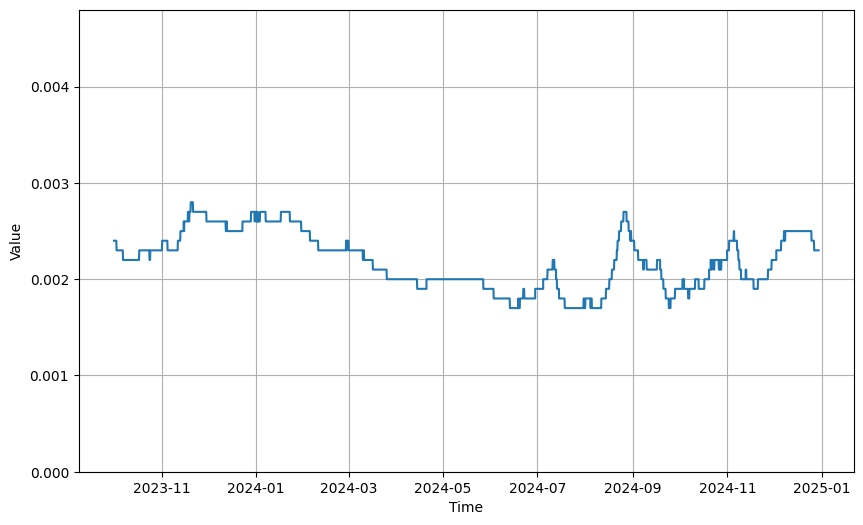

In [ ]:
time = prices_df["price_timestamp"].values
series = prices_df["spot_price"].values
roof = instance_info_df.loc[28368, "on_demand_price"]
plot_series(time, series, roof=roof)

In [11]:
def create_sequences(df: pd.DataFrame):
    sequence_length = CONFIG["sequence_length"]
    prediction_length = CONFIG["prediction_length"]
    window_step = CONFIG["window_step"]
    all_X, all_y = [], []

    for id_instance in df["id_instance"].unique():
        prices = torch.tensor(
            df[df["id_instance"] == id_instance]["spot_price"].values,
            dtype=torch.float32,
        ).clone().detach()
        if prices.shape[0] < sequence_length + prediction_length:
            continue
        windows = prices.unfold(0, sequence_length + prediction_length, window_step)
        all_X.append(windows[:, :sequence_length])
        all_y.append(windows[:, sequence_length:])

    X = torch.cat(all_X, dim=0).unsqueeze(-1)
    y = torch.cat(all_y, dim=0)
    return X, y

In [12]:
# Create validation and test data loaders
X_train, y_train = create_sequences(training_df)
X_val, y_val = create_sequences(validation_df)

/Users/adf/dev/beca/spot_predictor/model.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


Epoch [1/20], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [2/20], Train Loss: 0.0000, Val Loss: 0.0001
Epoch [3/20], Train Loss: 0.0001, Val Loss: 0.0000
Epoch [4/20], Train Loss: 0.0000, Val Loss: 0.0000
Checkpoint saved at epoch 5
Epoch [5/20], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [6/20], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [7/20], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [8/20], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [9/20], Train Loss: 0.0000, Val Loss: 0.0000
Checkpoint saved at epoch 10
Epoch [10/20], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [11/20], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [12/20], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [13/20], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [14/20], Train Loss: 0.0000, Val Loss: 0.0000
Checkpoint saved at epoch 15
Epoch [15/20], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [16/20], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [17/20], Train Loss: 0.0000, Val Loss: 0.0000
Epoch [18/20], Train Loss: 0.0000, Val 

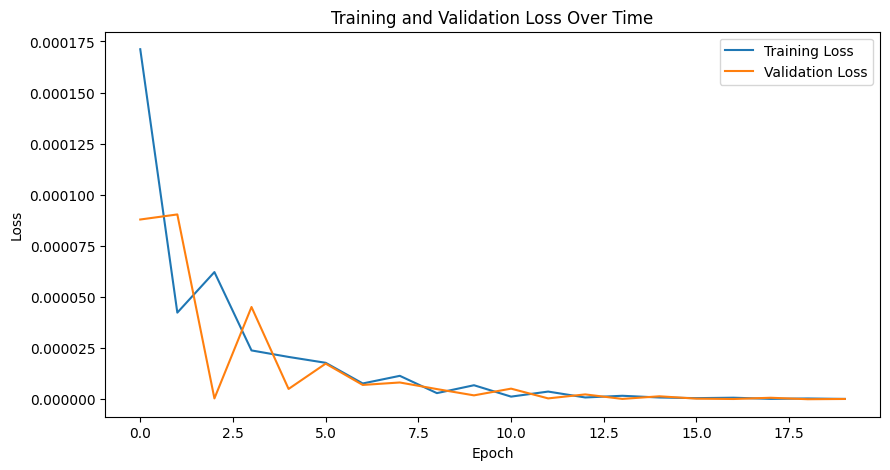

In [14]:
# Define model parameters
input_size = 1
hidden_size = 50
num_layers = 2
output_size = CONFIG["prediction_length"]
num_epochs = 20
batch_size = 64
learning_rate = 0.001

# Create the model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
model.device = torch.device("mps" if torch.mps.is_available() else "cpu")
model.to(model.device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Reshape the input tensors to the expected shape (batch_size, sequence_length, input_size)
X_train = X_train.reshape(-1, CONFIG["sequence_length"], input_size)
X_val = X_val.reshape(-1, CONFIG["sequence_length"], input_size)

train_loader = create_data_loader(X_train, y_train, batch_size)
val_loader = create_data_loader(X_val, y_val, batch_size)

train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

plot_training_loss(train_losses, val_losses)

In [16]:
# Evaluate the model on the test set
X_test, y_test = create_sequences(validation_df)
test_loader = create_data_loader(X_test, y_test, batch_size, shuffle=False)

test_loss = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0000


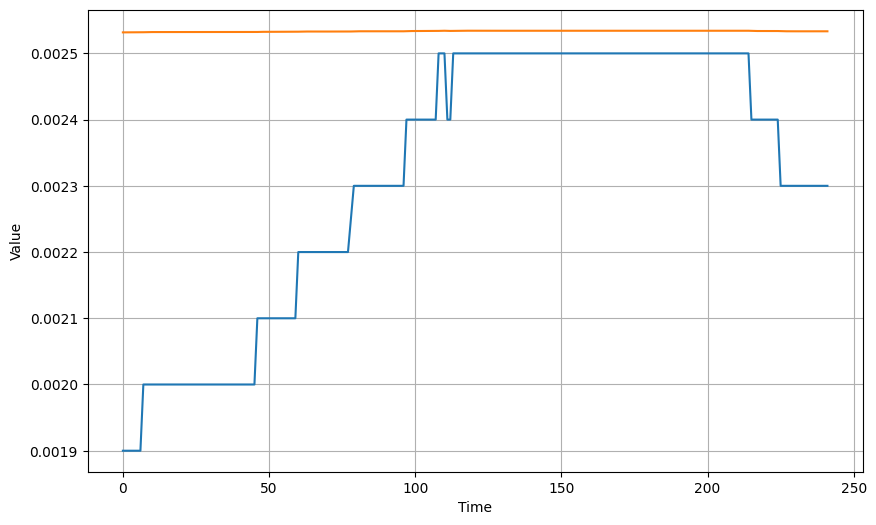

In [17]:
X_plot, y_plot = create_sequences(test_df[test_df["id_instance"] == 28368])
plot_loader = create_data_loader(X_plot, y_plot, batch_size, shuffle=False)

# Generate forecasts
forecasts = forecast(model, plot_loader)

# Reshape X_plot for plotting
X_plot_reshaped = X_plot.reshape(X_plot.shape[0], -1)

plot_series(range(len(y_plot)), (X_plot_reshaped[:, -1], forecasts))